This notebooks shows how to generate raster mask from the Global Mangrove Watch [dataset](https://data.unep-wcmc.org/datasets/4).

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio
from rasterio.warp import transform_bounds
import numpy as np
import scipy.ndimage as nd
from rscube import reproject_arr_to_match_profile, rasterize_shapes_to_array

In [2]:
DATA_DIR_NAME = f'data/asf_data_reprojected/'
DATA_DIR = Path(DATA_DIR_NAME)
DATA_DIR.exists()

True

In [3]:
dem_path = DATA_DIR/'dem.tif'
with rasterio.open(dem_path) as ds:
    dem = ds.read(1)
    dem_profile = ds.profile
    dem_bounds = ds.bounds
    dem_crs = ds.crs

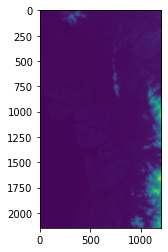

In [4]:
plt.imshow(dem)

In [5]:
dict(dem_crs)

{'init': 'epsg:32647'}

In [6]:
GMW_PATH = '/Volumes/BigData/GMW_001_GlobalMangroveWatch/01_Data/GMW_2007_v2.shp'

In [7]:
dem_bounds_4326 = transform_bounds(dem_profile['crs'], {'init': 'epsg:4326'}, *dem_bounds)
dem_bounds_4326

(100.45765325742471, 4.573041384938807, 100.78360494232957, 5.15655214948148)

/Users/cmarshak/anaconda3/envs/rscube/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


CPU times: user 472 ms, sys: 28.1 ms, total: 500 ms
Wall time: 508 ms


<AxesSubplot:>

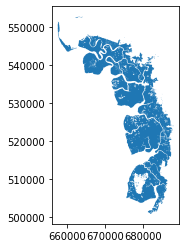

In [8]:
%%time

df_mangrove = gpd.read_file(GMW_PATH, bbox=dem_bounds_4326).to_crs(dict(dem_crs))
df_mangrove.plot()

In [9]:
df_mangrove.to_file(DATA_DIR.parent/'GMW_extent_cropped')

In [10]:
df_mangrove.head()

,ogc_fid,pxlval,geometry
0,45165.0,1,"POLYGON ((663022.902 552846.650, 663096.829 55..."
1,45166.0,1,"POLYGON ((663146.114 552846.926, 663343.253 55..."
2,45167.0,1,"POLYGON ((663466.575 552798.499, 663491.217 55..."
3,45168.0,1,"POLYGON ((664156.618 552775.478, 664205.903 55..."
4,45170.0,1,"POLYGON ((663590.063 552675.915, 663614.705 55..."


We first convert these shapes into a raster.

In [11]:
mangrove_mask = rasterize_shapes_to_array(df_mangrove.geometry, df_mangrove.pxlval, dem_profile, all_touched=False)

Now, we are going to provide a two pixel buffer in case the boundaries don't perfeclty match the mangrove extent.

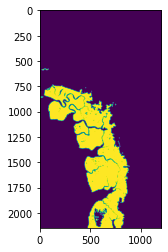

In [12]:
mangrove_mask = nd.binary_dilation(mangrove_mask.astype(int), iterations=2)
plt.imshow(mangrove_mask)

Now, we save the mask.

In [13]:
p_mangrove = dem_profile.copy()
p_mangrove['count'] = 1
p_mangrove['dtype'] = 'uint8'
p_mangrove['nodata'] = None

In [14]:
dest_dir = DATA_DIR
with rasterio.open(dest_dir/'mangrove_mask.tif', 'w', **p_mangrove) as ds:
    ds.write(mangrove_mask.astype(np.uint8), 1)